# DigiCow Farmer Training Adoption Challenge

## 1 Introduction

### 1.1 Aim: 
To predict which farmers will turn training into action

### 1.2 Problem Statement:
Access to high-quality agricultural training is just the first step toward improving productivity of farms. However, understanding which farmers adopt improved practices after training and why is a real challenge.

### 1.3 Business Understanding: 
DigiCow supports smallholder farmers through digital tools, extension services, and targetted training programmes. However, like many real-world interventions, adoption rates remain low and uneven. The ability to predict adoption early can enable DigiCow and its partners to prioritise follow-ups, tailor support more effectively, and design stronger extension strategies. 

### 1.4 Project Pitch: 
Predict the probability that a farmer will adopt a practice within 120 days of their first training, only using information available at the time of training. So the trained model must output predicted probabilities indicating the likelihood that a farmer will adopt a DigiCow-supported practice within the target time window (120 days of their first training). 

In [1]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
import ast
from sklearn.model_selection import KFold


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## 2 Dataset Overview

### 2.1 Data Loading

In [2]:
# Load datasets
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')
sample_sub = pd.read_csv('data/SampleSubmission.csv')
description = pd.read_csv('data/dataset_data_dictionary.csv')

In [3]:
description

,column_name,description
0,ID,unique identifier for each farmer entry
1,gender,Gender of the farmer
2,age,Age category of the farmer
3,registration,Registration method
4,belong_to_cooperative,Whether the farmer belongs to a cooperative (1...
5,county,County of residence
6,subcounty,Sub-county of residence
7,ward,Ward of residence
8,trainer,Trainer who delivered the first training
9,topics_list,List of possible training topics


In [4]:
sample_sub.head(2)

,ID,Target_AUC,Target_LogLoss
0,ID_KYO5JS,0,0
1,ID_846C1K,0,0


In [5]:
train_df.head(2)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,adopted_within_120_days,has_second_training
0,ID_QB363K,Female,Above 35,Ussd,1,Siaya,Alego Usonga,South East Alego,trainer_name_5,2024-07-07,"['Biosecurity In Poultry Farming,Calf Feeding,...",1.0,1.0,1,0,NaN,1,0,0
1,ID_J75OZ4,Female,Below 35,Ussd,0,Nandi,Chesumei,Lelmokwo Ngechek,trainer_name_3,2024-07-26,"['Calf Feeding,How To Rear A Calf With Unga Pr...",1.0,1.0,1,0,NaN,1,0,0


In [6]:
test_df.head(2)

,ID,gender,age,registration,belong_to_cooperative,county,subcounty,ward,trainer,first_training_date,topics_list,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,days_to_second_training,num_unique_trainers,has_second_training
0,ID_KYO5JS,Female,Below 35,Ussd,0,Siaya,Alego Usonga,West Alego,trainer_name_5,2024-07-10,"['Biosecurity In Poultry Farming,Calf Feeding,...",1.0,1.0,1,0,NaN,1,0
1,ID_846C1K,Male,Below 35,Ussd,0,Bungoma,Kanduyi,Musikoma,trainer_name_2,2024-07-20,"['Herd Health Management.,Poultry Health Manag...",1.0,1.0,1,0,NaN,1,0


### 2.2 Target Variable Analysis
- Based on the description df; the target variable is `adopted_within_120_days`.
- Perform high-level overview of the training and test datasets to investigate their respective structure and access readiness for modelling. 

In [7]:
# High-level datasets overview
print(f"\nTrain Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")
print(f"\nNumber of Features in Train: {train_df.shape[1]}")
print(f"Number of Features in Test: {test_df.shape[1]}")

# Check for target variable
if 'adopted_within_120_days' in train_df.columns and 'adopted_within_120_days' not in test_df.columns:
    print(f"\nTarget variable 'adopted_within_120_days' found in train set")
    print(f"Target variable absent from test set")
else:
    print("\n Check target variable presence!")


Train Dataset Shape: (11780, 19)
Test Dataset Shape: (5055, 18)

Number of Features in Train: 19
Number of Features in Test: 18

Target variable 'adopted_within_120_days' found in train set
Target variable absent from test set


In [8]:
# rename `adopted_within_120_days` to `target`
train_df = train_df.rename(columns={'adopted_within_120_days': 'target'})
train_df['target'] = train_df['target'].astype('object')

- Investigate distribuction of the target variable and examine potential class imbalance. According to Xiao et al. (2024), a categorical target variable's scope of class imbalance is a crucial determinant factor for appropriate modelling strategies. 


Target Distribution:
target
0    11485
1      295
Name: count, dtype: int64

Target Proportions:
target
0    0.974958
1    0.025042
Name: proportion, dtype: float64


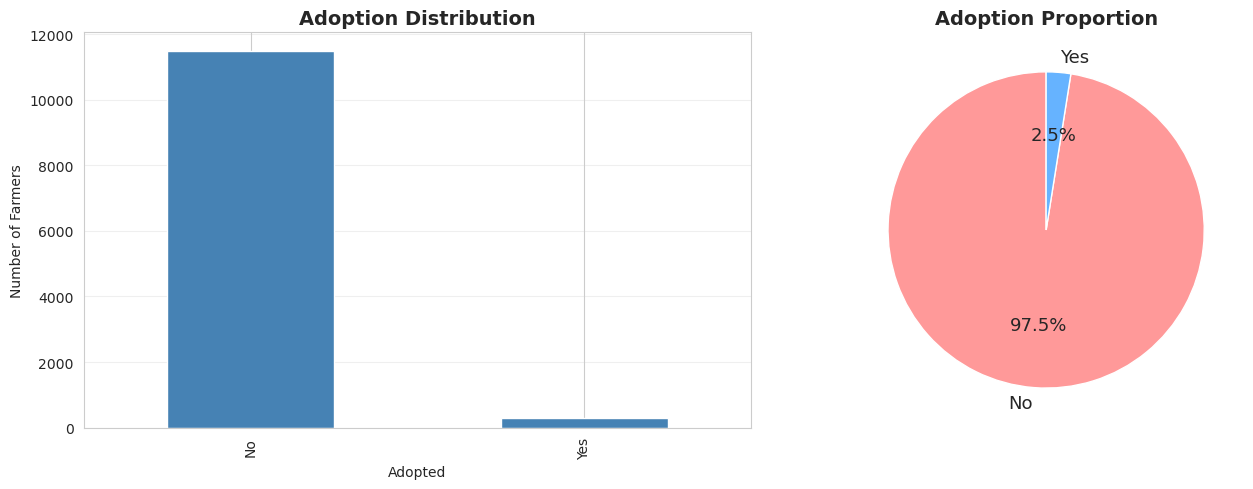


Class imbalance detected! Ratio: 38.93:1


In [9]:
# Target variable analysis
if 'target' in train_df.columns:
    print("\nTarget Distribution:")
    print(train_df['target'].value_counts().sort_index())
    print(f"\nTarget Proportions:")
    print(train_df['target'].value_counts(normalize=True).sort_index())
    
    # Create a mapping for target variable binary labels
    target_labels = {0: 'No', 1: 'Yes'}
    
    # Visualize target distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot with renamed labels
    counts = train_df['target'].value_counts().sort_index()
    counts.index = counts.index.map(target_labels)          
    counts.plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Adoption Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Adopted')
    axes[0].set_ylabel('Number of Farmers')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart with renamed labels
    target_counts = train_df['target'].value_counts().sort_index()
    target_counts.index = target_counts.index.map(target_labels) 
    axes[1].pie(target_counts, 
                 labels=target_counts.index,
                 autopct='%1.1f%%',
                 startangle=90,
                 colors=['#ff9999', '#66b3ff'],
                 textprops={'fontsize': 13})
    axes[1].set_title('Adoption Proportion', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance 
    class_ratio = train_df['target'].value_counts().max() / train_df['target'].value_counts().min()
    if class_ratio > 1.5:
        print(f"\nClass imbalance detected! Ratio: {class_ratio:.2f}:1")
    else:
        print(f"\nClasses are relatively balanced. Ratio: {class_ratio:.2f}:1")

### 2.2 Basic Dataset Information

In [10]:
# Print 

print("\nTraining Dataset Information")
print(train_df.info())

print("\nTest Dataset Information")
print(test_df.info())


Training Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       11780 non-null  object 
 1   gender                   11780 non-null  object 
 2   age                      11780 non-null  object 
 3   registration             11780 non-null  object 
 4   belong_to_cooperative    11780 non-null  int64  
 5   county                   11780 non-null  object 
 6   subcounty                11780 non-null  object 
 7   ward                     11780 non-null  object 
 8   trainer                  11780 non-null  object 
 9   first_training_date      11780 non-null  object 
 10  topics_list              11780 non-null  object 
 11  num_trainings_30d        11780 non-null  float64
 12  num_trainings_60d        11780 non-null  float64
 13  num_total_trainings      11780 non-null  int64

In [11]:
# Convert 'first_training_date' to datetime format
train_df['first_training_date'] = pd.to_datetime(train_df['first_training_date'])
test_df['first_training_date'] = pd.to_datetime(test_df['first_training_date'])

### 2.3 Missing Values Analysis


TRAIN SET - Columns with Missing Values:
                 Column  Missing_Count  Percentage
days_to_second_training          11667   99.040747


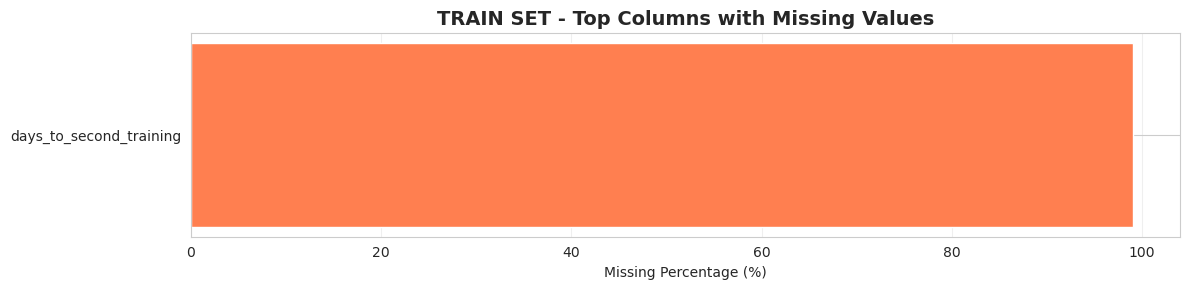


TEST SET - Columns with Missing Values:
                 Column  Missing_Count  Percentage
days_to_second_training           5007   99.050445


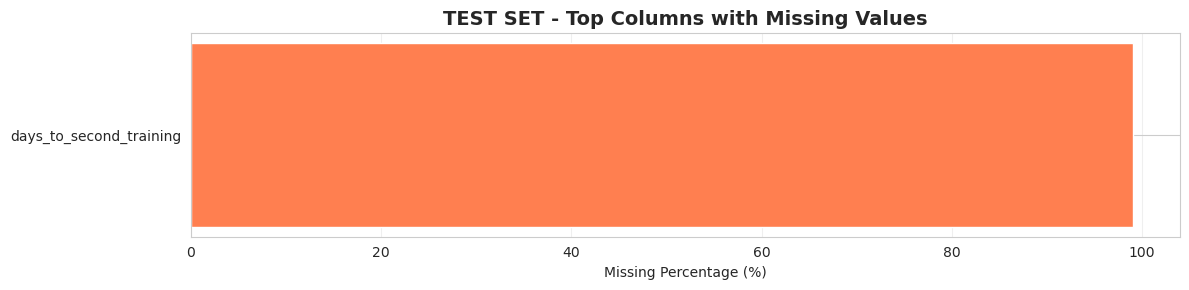

In [12]:
# Missing values check
def analyze_missing(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    }).query('Missing_Count > 0').sort_values('Percentage', ascending=False)

    print(f"\n{name} - Columns with Missing Values:")
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))

        # Visualize top missing columns
        if len(missing_df) > 0:
            top_missing = missing_df.head(15)
            plt.figure(figsize=(12, 3))
            plt.barh(top_missing['Column'], top_missing['Percentage'], color='coral')
            plt.xlabel('Missing Percentage (%)')
            plt.title(f'{name} - Top Columns with Missing Values', fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values found!")

    return missing_df

train_missing = analyze_missing(train_df, "TRAIN SET")
test_missing = analyze_missing(test_df, "TEST SET")

- Due to the high percentage of missing data for the `days_to_second_training` for both the training and test datasets; the feature is eliminated.

In [13]:
# Remove the column from both dataframes
columns_to_drop = ['days_to_second_training']

train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df   = test_df.drop(columns=columns_to_drop,   errors='ignore')

### 2.4 Numerical Features Analysis

- Examine the numerical features to understand their respective distribuction, scales, and summary statistics. According to Zhou et al.(2017), evaluating the distribuction of numerical features is critical for:
   1. Feature scalling and normalization.
   2. Outlier treatment.
   3. Informing appropriate modelling techniques. 

In [14]:
# Identify numerical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

print("\nStatistical Summary:")
train_df[numerical_cols].describe()


Statistical Summary:


,belong_to_cooperative,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,num_unique_trainers,has_second_training
count,11780.000000,11780.000000,11780.000000,11780.000000,11780.000000,11780.0,11780.000000
mean,0.318676,1.013328,1.013328,1.013328,0.013328,1.0,0.009593
std,0.465983,0.151655,0.151655,0.151655,0.151655,0.0,0.097475
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
max,1.000000,5.000000,5.000000,5.000000,4.000000,1.0,1.000000


In [15]:
# Examine respective value counts
features = ['belong_to_cooperative', 'num_trainings_30d', 'num_trainings_60d',
            'num_total_trainings', 'num_repeat_trainings', 'num_unique_trainers', 'has_second_training']

for col in features:
    print(f" Value Counts for: {col}")
    print(train_df[col].value_counts())
    print("\n") 

 Value Counts for: belong_to_cooperative
belong_to_cooperative
0    8026
1    3754
Name: count, dtype: int64


 Value Counts for: num_trainings_30d
num_trainings_30d
1.0    11667
2.0       80
3.0       25
4.0        5
5.0        3
Name: count, dtype: int64


 Value Counts for: num_trainings_60d
num_trainings_60d
1.0    11667
2.0       80
3.0       25
4.0        5
5.0        3
Name: count, dtype: int64


 Value Counts for: num_total_trainings
num_total_trainings
1    11667
2       80
3       25
4        5
5        3
Name: count, dtype: int64


 Value Counts for: num_repeat_trainings
num_repeat_trainings
0    11667
1       80
2       25
3        5
4        3
Name: count, dtype: int64


 Value Counts for: num_unique_trainers
num_unique_trainers
1    11780
Name: count, dtype: int64


 Value Counts for: has_second_training
has_second_training
0    11667
1      113
Name: count, dtype: int64




In [16]:
# Identify numerical columns
numerical_cols = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

print("\nStatistical Summary:")
train_df[numerical_cols].describe()


Statistical Summary:


,belong_to_cooperative,num_trainings_30d,num_trainings_60d,num_total_trainings,num_repeat_trainings,num_unique_trainers,has_second_training
count,11780.000000,11780.000000,11780.000000,11780.000000,11780.000000,11780.0,11780.000000
mean,0.318676,1.013328,1.013328,1.013328,0.013328,1.0,0.009593
std,0.465983,0.151655,0.151655,0.151655,0.151655,0.0,0.097475
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000
max,1.000000,5.000000,5.000000,5.000000,4.000000,1.0,1.000000


In [17]:
# Examine respective value counts
features = ['belong_to_cooperative', 'num_trainings_30d', 'num_trainings_60d',
            'num_total_trainings', 'num_repeat_trainings', 'num_unique_trainers', 'has_second_training']

for col in features:
    print(f" Value Counts for: {col}")
    print(test_df[col].value_counts())
    print("\n") 

 Value Counts for: belong_to_cooperative
belong_to_cooperative
0    3420
1    1635
Name: count, dtype: int64


 Value Counts for: num_trainings_30d
num_trainings_30d
1.0    5007
2.0      32
3.0      11
4.0       4
6.0       1
Name: count, dtype: int64


 Value Counts for: num_trainings_60d
num_trainings_60d
1.0    5007
2.0      32
3.0      11
4.0       4
6.0       1
Name: count, dtype: int64


 Value Counts for: num_total_trainings
num_total_trainings
1    5007
2      32
3      11
4       4
6       1
Name: count, dtype: int64


 Value Counts for: num_repeat_trainings
num_repeat_trainings
0    5007
1      32
2      11
3       4
5       1
Name: count, dtype: int64


 Value Counts for: num_unique_trainers
num_unique_trainers
1    5055
Name: count, dtype: int64


 Value Counts for: has_second_training
has_second_training
0    5007
1      48
Name: count, dtype: int64




- It is evident that `belong_to_cooperative`, and `has_second_training` are indeed categorical in nature.
- The value_counts for `num_unique_trainers` reveals all rows are assigned to 1.

Thus, the numerical features are converted to object and `num_unique_trainers` removed from feature set. 

In [18]:
# Drop unwanted column
train_df.drop(columns='num_unique_trainers', errors='ignore', inplace=True)
test_df.drop(columns='num_unique_trainers',  errors='ignore', inplace=True)

# Convert to object (categorical-like treatment)
cols = [
    'belong_to_cooperative',
    'has_second_training'
]

for df in [train_df, test_df]:
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype('object')

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     11780 non-null  object        
 1   gender                 11780 non-null  object        
 2   age                    11780 non-null  object        
 3   registration           11780 non-null  object        
 4   belong_to_cooperative  11780 non-null  object        
 5   county                 11780 non-null  object        
 6   subcounty              11780 non-null  object        
 7   ward                   11780 non-null  object        
 8   trainer                11780 non-null  object        
 9   first_training_date    11780 non-null  datetime64[ns]
 10  topics_list            11780 non-null  object        
 11  num_trainings_30d      11780 non-null  float64       
 12  num_trainings_60d      11780 non-null  float64       
 13  n

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5055 non-null   object        
 1   gender                 5055 non-null   object        
 2   age                    5055 non-null   object        
 3   registration           5055 non-null   object        
 4   belong_to_cooperative  5055 non-null   object        
 5   county                 5055 non-null   object        
 6   subcounty              5055 non-null   object        
 7   ward                   5055 non-null   object        
 8   trainer                5055 non-null   object        
 9   first_training_date    5055 non-null   datetime64[ns]
 10  topics_list            5055 non-null   object        
 11  num_trainings_30d      5055 non-null   float64       
 12  num_trainings_60d      5055 non-null   float64       
 13  num

### 2.5 Categorical Features Analysis

Examine the categorical features focusing on respective variety, and uniqueness to ensure that these variables are handled efficiently and appropriately during feature engineering and model training. 

Investing categorical features also facilitates: 

- **Cardinality Analysis :** For each categorical feature, the number of unique values is computed to examine respective cardinality. According to Nargesian et al. (2017), comprehending categorical cardinality is vital for guiding encoding strategy selection.
    1. Low Cardinality: One-hot encoding.
    2. High Cardinality: Target encoding, frequency encoding, or embedding-based approaches.


- **Overfitting Likelihood :** Examine categorical features that have a significant potential to cause overfitting or increase model complexity unncessarily. 

In [21]:
# Categorical features' anaysis

# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if 'ID' in categorical_cols:
    categorical_cols.remove('ID')

print(f"\nCategorical Features ({len(categorical_cols)}):")
print(categorical_cols)

# Cardinality analysis
print("\nCardinality (Unique Values) for Categorical Features (train_df):")
cardinality_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Unique_Values': [train_df[col].nunique() for col in categorical_cols]
}).sort_values('Unique_Values', ascending=False)
print(cardinality_df.to_string(index=False))


Categorical Features (11):
['gender', 'age', 'registration', 'belong_to_cooperative', 'county', 'subcounty', 'ward', 'trainer', 'topics_list', 'target', 'has_second_training']

Cardinality (Unique Values) for Categorical Features (train_df):
              Feature  Unique_Values
          topics_list           2175
                 ward             51
            subcounty             17
               county              5
              trainer              5
               gender              2
                  age              2
         registration              2
belong_to_cooperative              2
               target              2
  has_second_training              2


In [22]:
# Categorical features' anaysis

# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object']).columns.tolist()
if 'ID' in categorical_cols:
    categorical_cols.remove('ID')

print(f"\nCategorical Features ({len(categorical_cols)}):")
print(categorical_cols)

# Cardinality analysis
print("\nCardinality (Unique Values) for Categorical Features (test_df):")
cardinality_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Unique_Values': [test_df[col].nunique() for col in categorical_cols]
}).sort_values('Unique_Values', ascending=False)
print(cardinality_df.to_string(index=False))


Categorical Features (10):
['gender', 'age', 'registration', 'belong_to_cooperative', 'county', 'subcounty', 'ward', 'trainer', 'topics_list', 'has_second_training']

Cardinality (Unique Values) for Categorical Features (test_df):
              Feature  Unique_Values
          topics_list           1222
                 ward             51
            subcounty             19
               county              5
              trainer              5
               gender              2
                  age              2
         registration              2
belong_to_cooperative              2
  has_second_training              2


| Feature                  | Unique Values | Cardinality Level     | Risk Level       |
|--------------------------|---------------|-----------------------|------------------|
| topics_list              | 2175          | Very High             | Very High        |
| ward                     | 51            | Medium-High           | Medium-High      |
| subcounty                | 17            | Medium                | Medium           |
| county                   | 5             | Low                   | Low              |
| trainer                  | 5             | Low                   | Low              |
| num_trainings_30d        | 5             | Low                   | Low              |
| num_trainings_60d        | 5             | Low                   | Low              |
| num_total_trainings      | 5             | Low                   | Low              |
| num_repeat_trainings     | 5             | Low                   | Low              |
| gender                   | 2             | Binary                | Low              |
| age                      | 2             | Binary                | Low              |
| registration             | 2             | Binary                | Low              |
| belong_to_cooperative    | 2             | Binary                | Low              |
| has_second_training      | 2             | Binary                | Low              |

#### 2.5.1 Examining `ward` feature

In [23]:
test_df['ward'].unique()

array(['West Alego', 'Musikoma', 'South East Alego', 'Ugunja', 'Kimaeti',
       'Siaya Township', 'Central Gem', 'South Gem', 'Lelmokwo Ngechek',
       'Central Alego', 'Ndalat', 'North Alego', 'Siboti', 'Kilibwoni',
       'Kabisaga', 'Bumula', 'Kosirai', 'Chemundu/Kapngetuny', 'Kabula',
       'Kabiyet', 'Sigomere', 'Bukembe East', 'Kaptel/Kamoiywo',
       'West Bukusu', 'Matisi', 'Sangalo Kebulonik', 'Kabuchai/Chwele',
       'East Gem', 'Simat Kapseret', 'Saboti', 'Mois Bridge', 'Kwanza',
       'South Bukusu', 'Bwake/Luuya', 'Kurgung/Surungai', 'Kinyoro',
       'Makutano', 'Yala Township', 'Township', 'Select Your Ward',
       'Marakaru/Tuuti', 'North Sakwa', 'East Asembo', 'Kipkaren',
       'North Ugenya', 'Bukembe West', 'Chepkunyuk', 'Chepterwai',
       'Khalaba', 'West Uyoma', 'West Sangalo'], dtype=object)

In [24]:
train_df['ward'].unique()

array(['South East Alego', 'Lelmokwo Ngechek', 'Kimaeti',
       'Siaya Township', 'Ndalat', 'Ugunja', 'West Alego', 'Musikoma',
       'Central Alego', 'Central Gem', 'North Alego', 'Kabisaga',
       'South Gem', 'Kabiyet', 'Siboti', 'Bumula', 'Sigomere', 'Kabula',
       'Kilibwoni', 'Kosirai', 'Bukembe East', 'Kaptel/Kamoiywo',
       'Chemundu/Kapngetuny', 'Yala Township', 'Sangalo Kebulonik',
       'Matisi', 'East Gem', 'Tuwani', 'Kabuchai/Chwele',
       'Simat Kapseret', 'Saboti', 'West Bukusu', 'Kwanza', 'Mois Bridge',
       'South Bukusu', 'Soy', 'Bwake/Luuya', 'Kinyoro',
       'Kurgung/Surungai', 'Township', 'Marakaru/Tuuti', 'Kipkaren',
       'Khalaba', 'East Asembo', 'North Ugenya', 'West Uyoma',
       'Bukembe West', 'Chepterwai', 'West Sangalo', 'North Sakwa',
       'Chepkunyuk'], dtype=object)

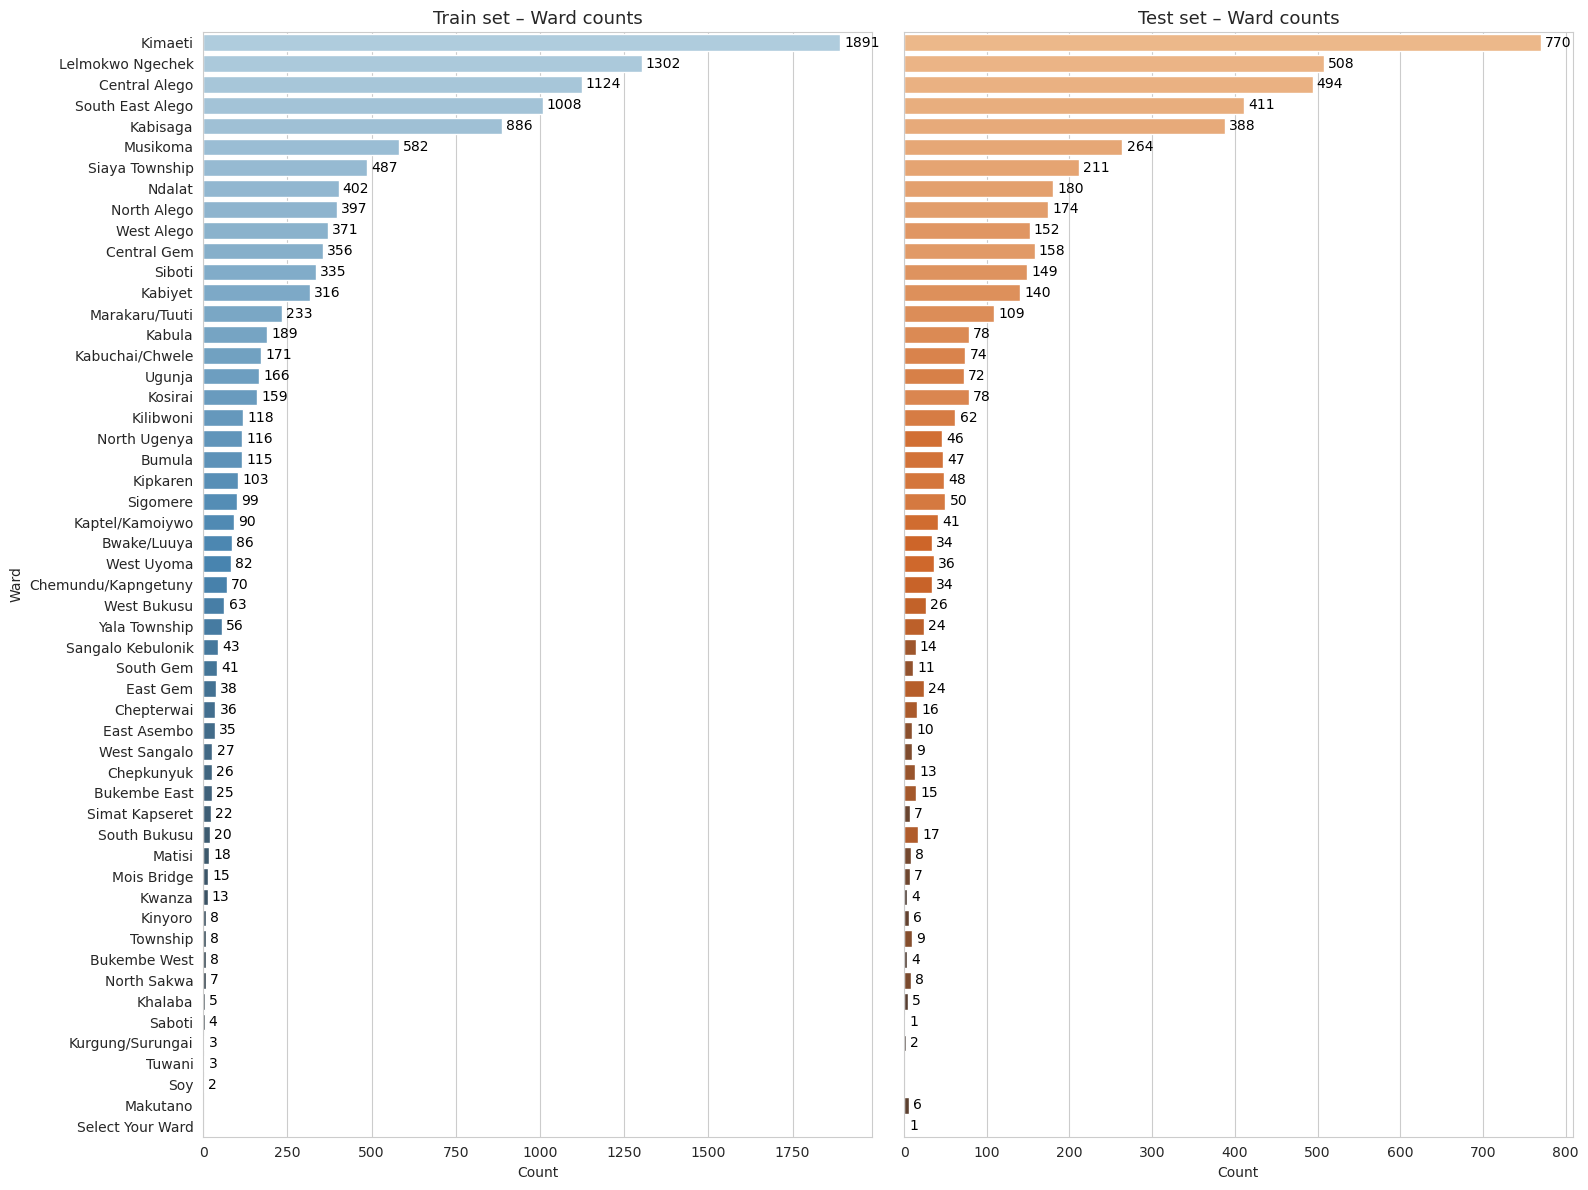

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='ward', order=train_df['ward'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Ward counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Ward')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='ward', order=test_df['ward'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Ward counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### 2.5.2 Examining `subcounty` feature

In [26]:
test_df['subcounty'].unique()

array(['Alego Usonga', 'Kanduyi', 'Ugunja', 'Bumula', 'Gem', 'Chesumei',
       'Mosop', 'Emgwen', 'Saboti', 'Kabuchai', 'Kapseret', 'Soy',
       'Kwanza', 'Cherangany', 'Select Your Sub County', 'Bondo',
       'Rarieda', 'Ugenya', 'Nandi Hills'], dtype=object)

In [27]:
train_df['subcounty'].unique()

array(['Alego Usonga', 'Chesumei', 'Bumula', 'Mosop', 'Ugunja', 'Kanduyi',
       'Gem', 'Emgwen', 'Saboti', 'Kabuchai', 'Kapseret', 'Kwanza', 'Soy',
       'Rarieda', 'Ugenya', 'Bondo', 'Nandi Hills'], dtype=object)

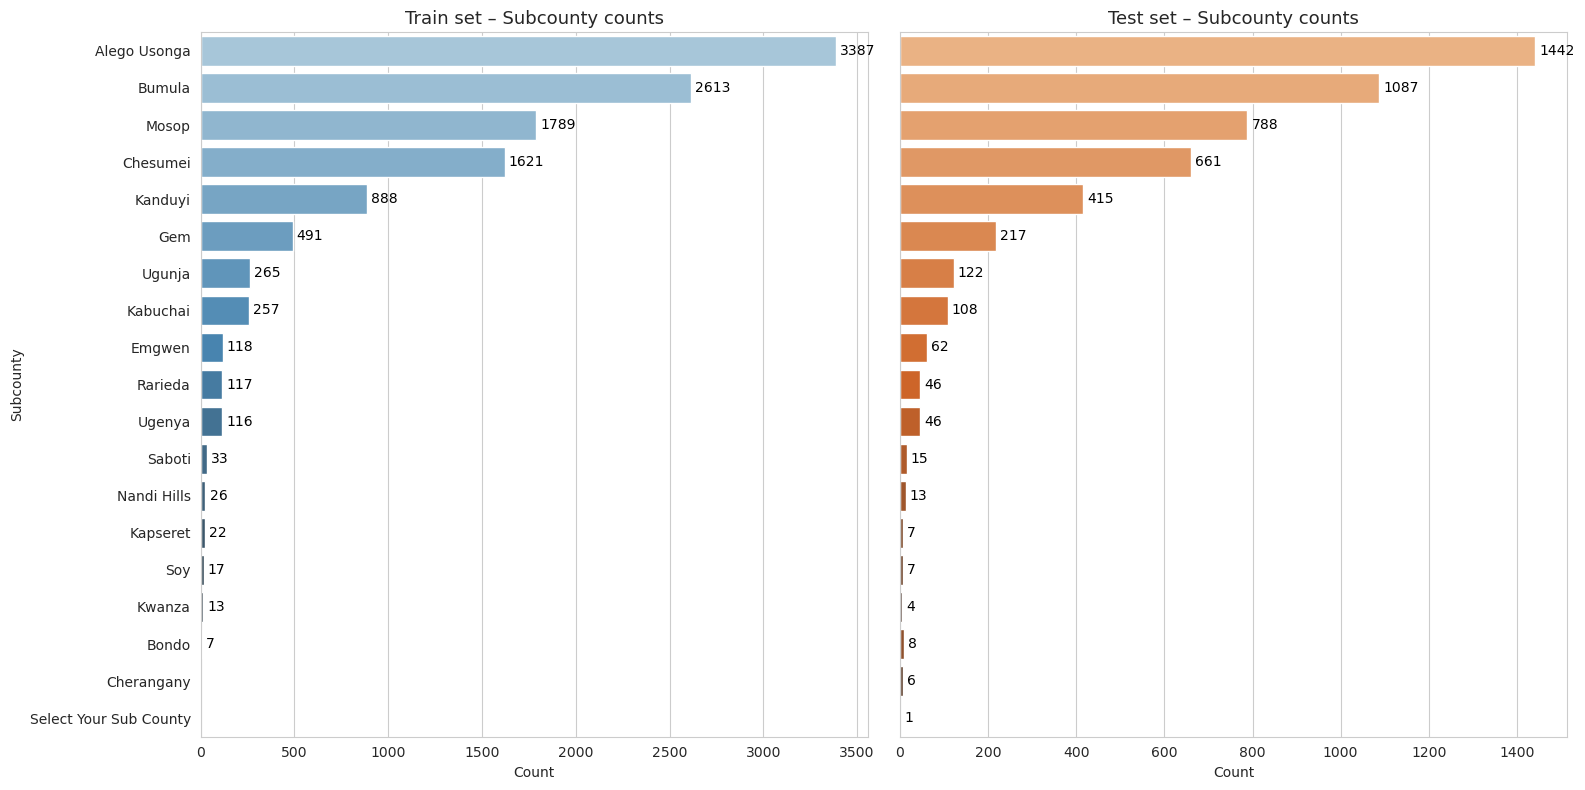

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='subcounty', order=train_df['subcounty'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Subcounty counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Subcounty')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='subcounty', order=test_df['subcounty'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Subcounty counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.3 Examining `county` feature

In [29]:
test_df['county'].unique()

array(['Siaya', 'Bungoma', 'Nandi', 'Trans Nzoia', 'Uasin Gishu'],
      dtype=object)

In [30]:
train_df['county'].unique()

array(['Siaya', 'Nandi', 'Bungoma', 'Trans Nzoia', 'Uasin Gishu'],
      dtype=object)

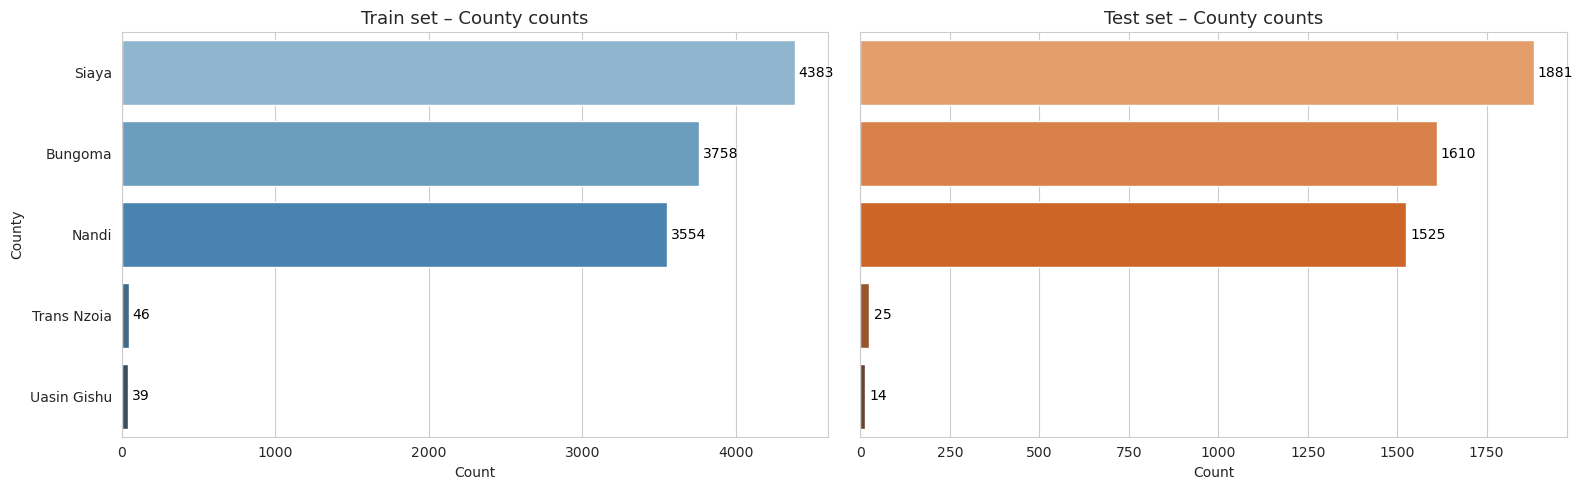

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='county', order=train_df['county'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – County counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('County')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='county', order=test_df['county'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – County counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.4 Examining `trainer` feature

In [32]:
test_df['trainer'].unique()

array(['trainer_name_5', 'trainer_name_2', 'trainer_name_3',
       'trainer_name_4', 'Other'], dtype=object)

In [33]:
train_df['trainer'].unique()

array(['trainer_name_5', 'trainer_name_3', 'trainer_name_2',
       'trainer_name_4', 'Other'], dtype=object)

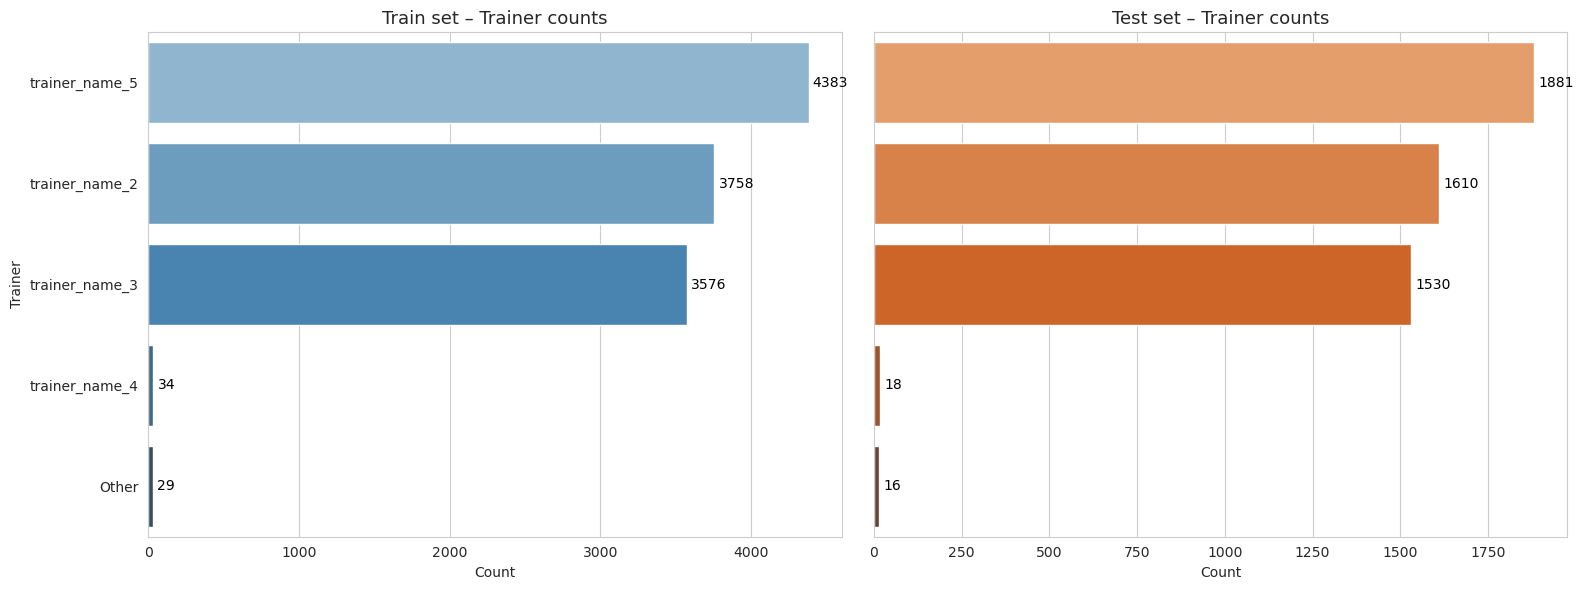

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='trainer', order=train_df['trainer'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Trainer counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Trainer')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='trainer', order=test_df['trainer'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Trainer counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.5 Examining `gender` feature

In [35]:
test_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [36]:
train_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

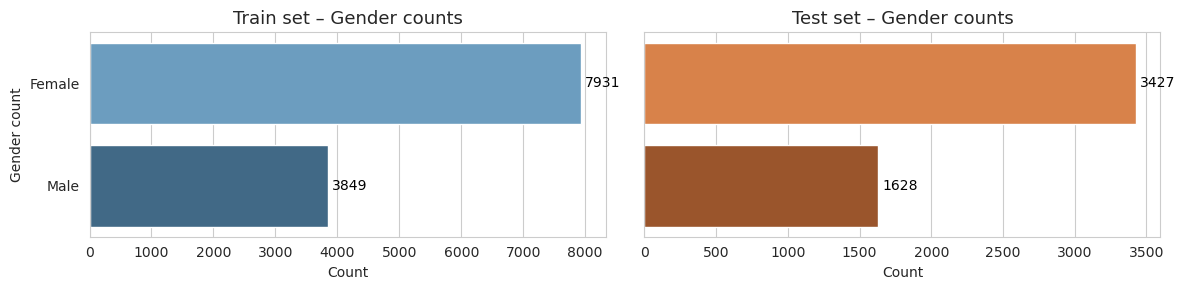

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='gender', order=train_df['gender'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Gender counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Gender count')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='gender', order=test_df['gender'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Gender counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.6 Examining `age` feature

In [38]:
test_df['age'].unique()

array(['Below 35', 'Above 35'], dtype=object)

In [39]:
train_df['age'].unique()

array(['Above 35', 'Below 35'], dtype=object)

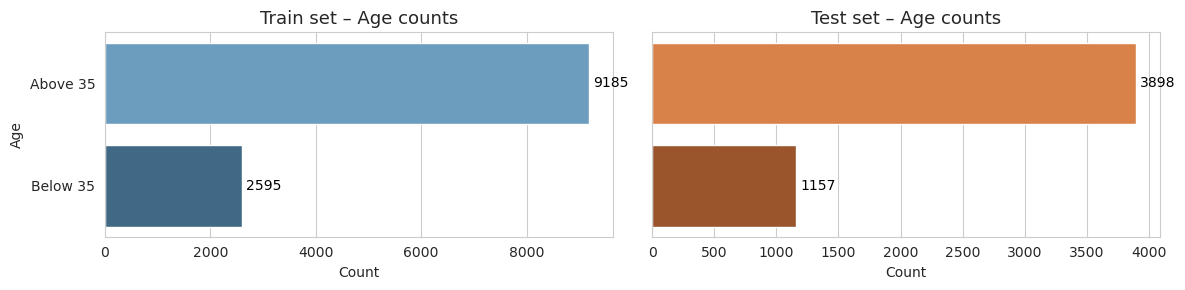

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='age', order=train_df['age'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Age counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Age')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='age', order=test_df['age'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Age counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.7 Examining `registration` feature

In [41]:
test_df['registration'].unique()

array(['Ussd', 'Manual'], dtype=object)

In [42]:
train_df['registration'].unique()

array(['Ussd', 'Manual'], dtype=object)

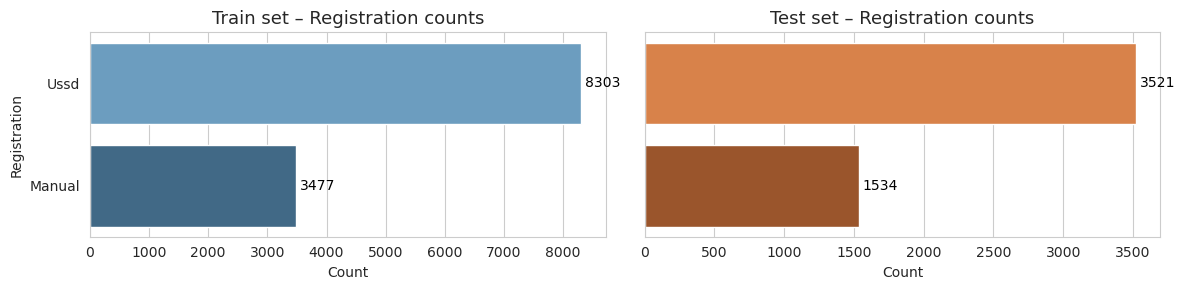

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='registration', order=train_df['registration'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Registration counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Registration')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='registration', order=test_df['registration'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Registration counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.8 Examining `belong_to_cooperative` feature

In [44]:
test_df['belong_to_cooperative'].unique()

array([0, 1], dtype=object)

In [45]:
train_df['belong_to_cooperative'].unique()

array([1, 0], dtype=object)

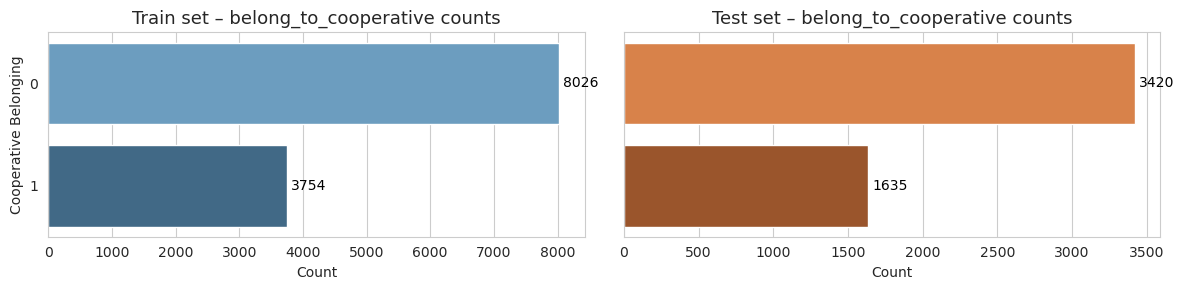

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='belong_to_cooperative', order=train_df['belong_to_cooperative'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – belong_to_cooperative counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Cooperative Belonging')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='belong_to_cooperative', order=test_df['belong_to_cooperative'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – belong_to_cooperative counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

#### 2.5.9 Examining `has_second_training` feature

In [47]:
test_df['has_second_training'].unique()

array([0, 1], dtype=object)

In [48]:
train_df['has_second_training'].unique()

array([0, 1], dtype=object)

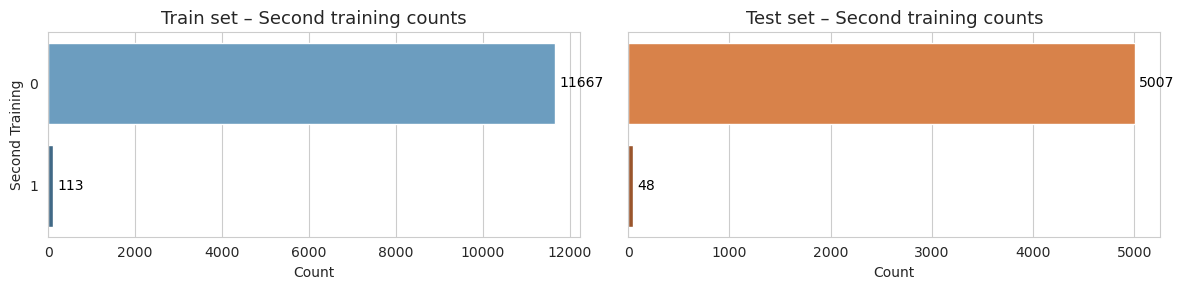

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='has_second_training', order=train_df['has_second_training'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Second training counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Second Training')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='has_second_training', order=test_df['has_second_training'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Second training counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

### 2.5.10 Addressing Problematic Issues for `ward` and `subcounty` features

In [50]:
# Define known categories from TRAIN only
known_wards = set(train_df['ward'].unique())
known_subcounties = set(train_df['subcounty'].unique())

# Function to replace unseen categories with 'Other'
def replace_unseen_categories(df, col, known_set):
    df = df.copy()
    df[col] = df[col].apply(lambda x: x if x in known_set else 'Other')
    return df

# Apply to both train and test for consistency
train_df = replace_unseen_categories(train_df, 'ward', known_wards)
test_df = replace_unseen_categories(test_df, 'ward', known_wards)

train_df = replace_unseen_categories(train_df, 'subcounty', known_subcounties)
test_df = replace_unseen_categories(test_df, 'subcounty', known_subcounties)

# Collapse placeholder values like "Select Your..." explicitly
placeholder_values = ['Select Your Ward', 'Select Your Sub County']
for col in ['ward', 'subcounty']:
    if col in train_df.columns:
        train_df[col] = train_df[col].replace(placeholder_values, 'Other')
    if col in test_df.columns:
        test_df[col] = test_df[col].replace(placeholder_values, 'Other')

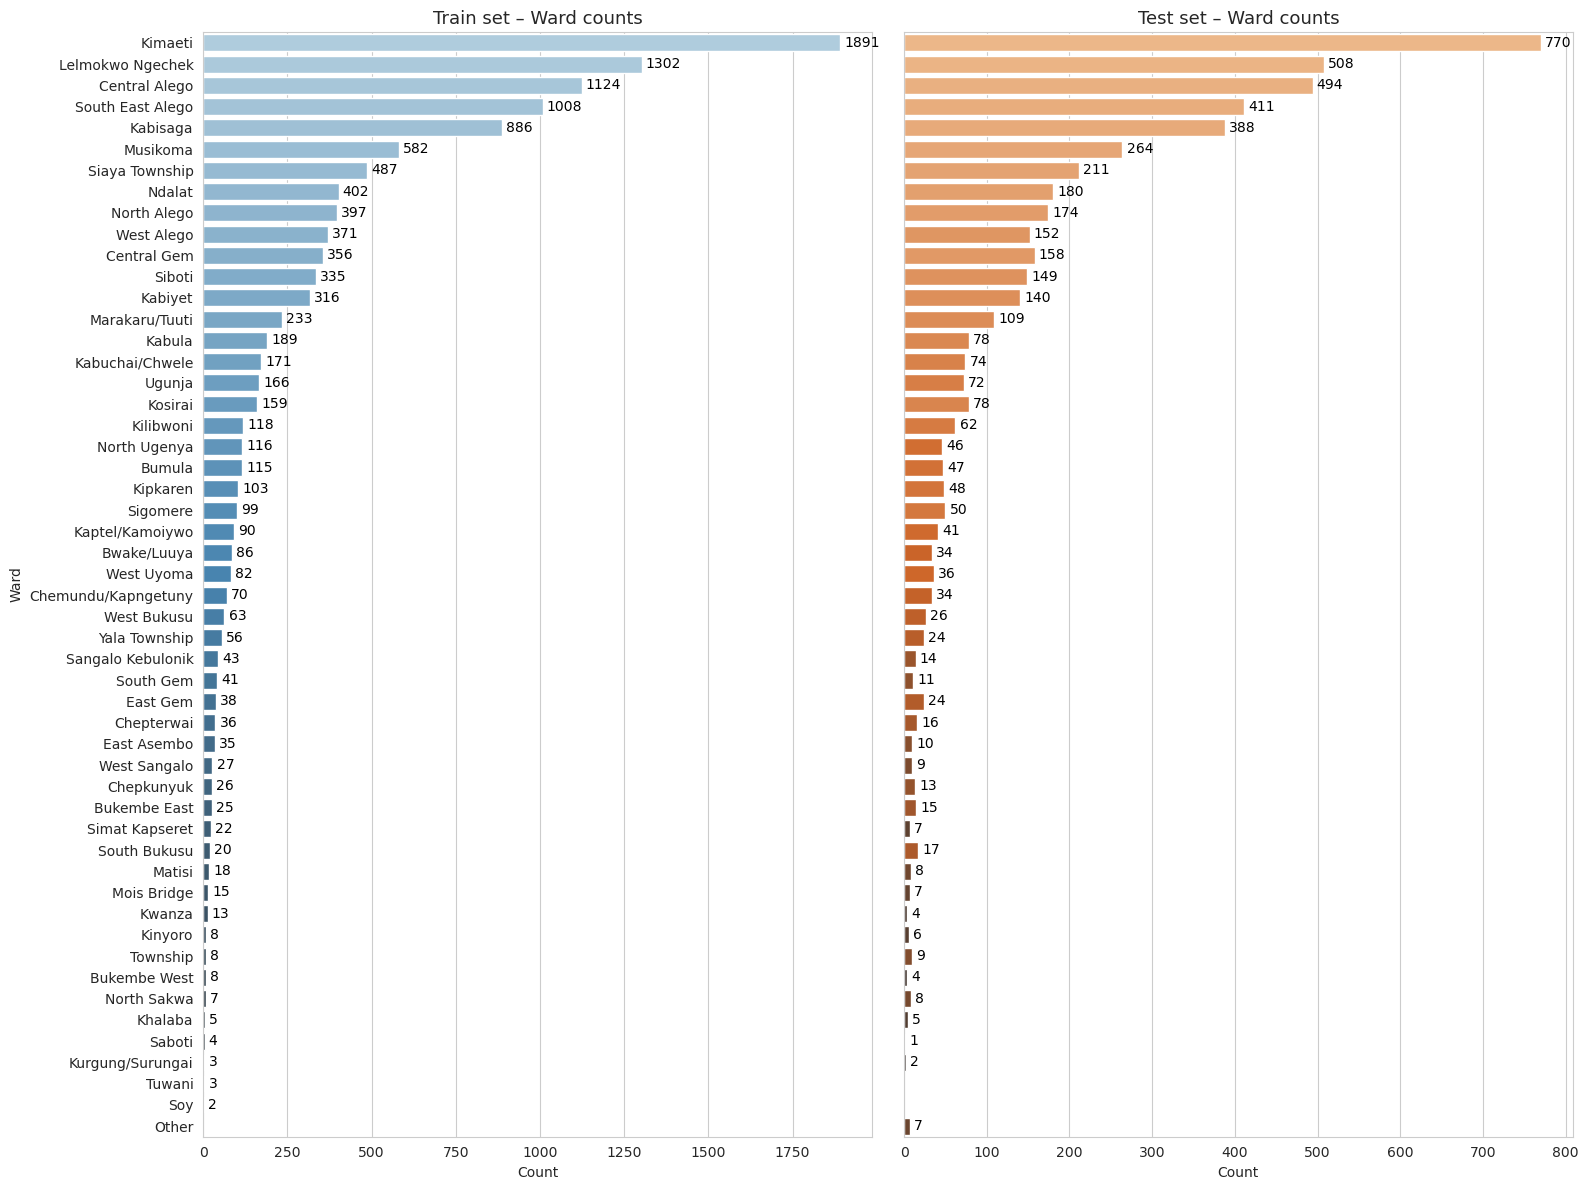

In [51]:
# Check if problematic issue addresed for `ward` feature
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='ward', order=train_df['ward'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Ward counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Ward')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='ward', order=test_df['ward'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Ward counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

plt.tight_layout()
plt.show()

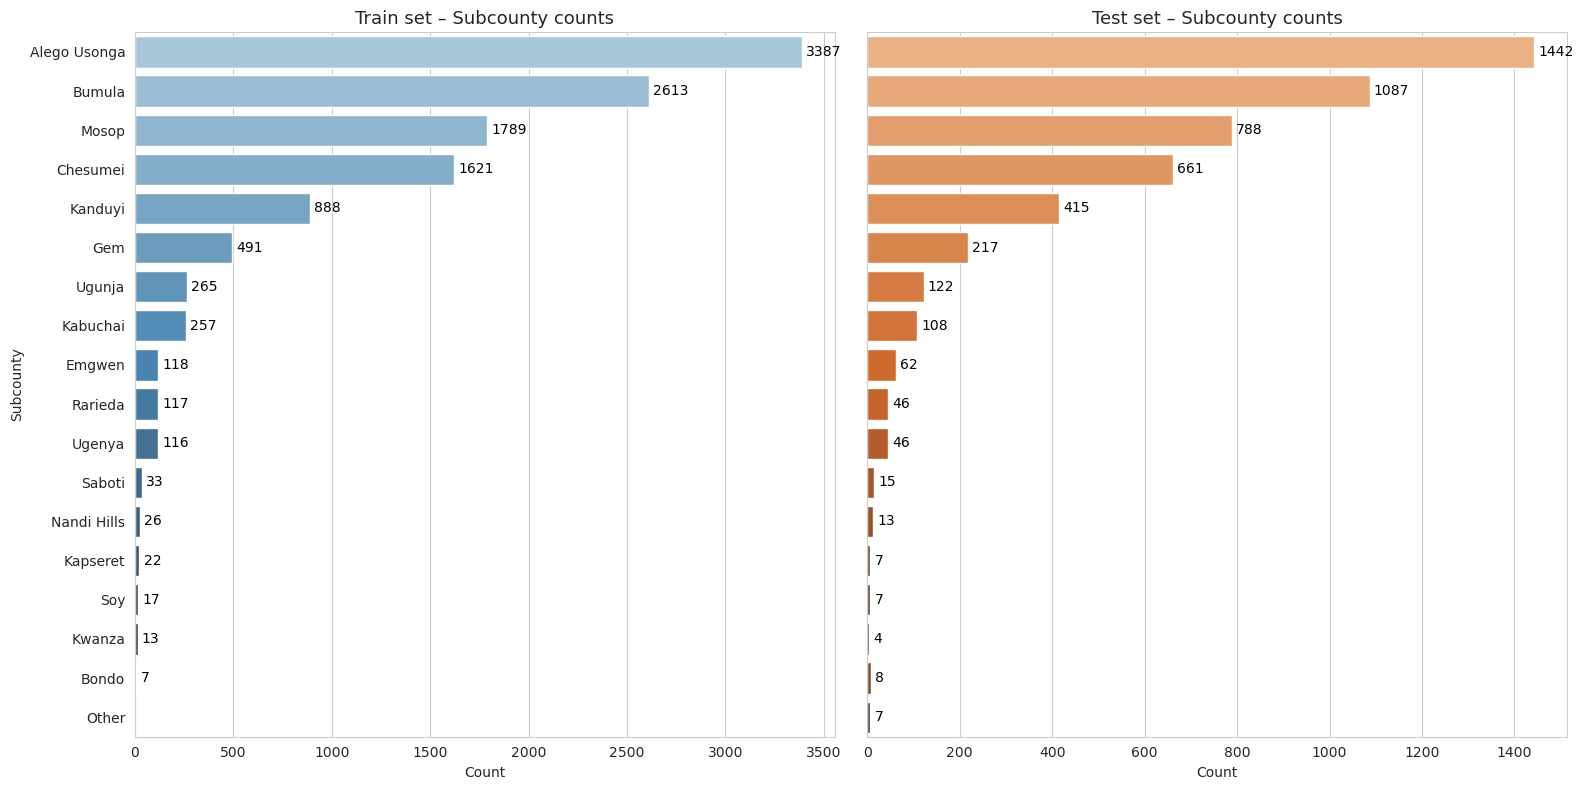

In [52]:
# Check if problematic issue addresed for `subcounty` feature
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Train
ax = axes[0]
sns.countplot(data=train_df, y='subcounty', order=train_df['subcounty'].value_counts().index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train set – Subcounty counts', fontsize=13)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Subcounty')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Test
ax = axes[1]
sns.countplot(data=test_df, y='subcounty', order=test_df['subcounty'].value_counts().index, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Test set – Subcounty counts', fontsize=13)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')
plt.tight_layout()
plt.show()

### 2.6 Categorical Features vs. Target Analysis 

- Leverage cross-tabulation to compute the percentage distribuction of the categorical features within each `target` class.
- The findings are crucial in highlighting potential correlations between categorical features and `target`.
- Feature-target relationships are crucial for informing: feature selection, encoding strategies, and model interpretability.
- Features with strong association with `target` are prime candidates for inclusion in predictive models.
- Crucial for providing a solid foundations for data-drive feature engineering and guide prioritization strategy for features with a high potential for driving models's predictive performance. 

In [53]:
# Categorical features vs. target analysis 
if 'target' in train_df.columns:
    print("Categorical Features' Relationships with Target")

    # Categorical features vs target
    print("\n Key Categorical Features by Target:")
    key_cat = ['gender', 'age', 'registration', 'belong_to_cooperative', 
               'trainer', 'has_second_training', 'county', 'subcounty', 'ward']
    for col in key_cat:
        if col in train_df.columns:
            print(f"\n{col} distribution by Target:")
            ct = pd.crosstab(train_df[col], train_df['target'], normalize='index') * 100
            print(ct.round(2))

Categorical Features' Relationships with Target

 Key Categorical Features by Target:

gender distribution by Target:
target      0     1
gender             
Female  97.38  2.62
Male    97.74  2.26

age distribution by Target:
target        0     1
age                  
Above 35  97.41  2.59
Below 35  97.80  2.20

registration distribution by Target:
target            0     1
registration             
Manual        98.62  1.38
Ussd          97.03  2.97

belong_to_cooperative distribution by Target:
target                     0     1
belong_to_cooperative             
0                      97.47  2.53
1                      97.55  2.45

trainer distribution by Target:
target               0     1
trainer                     
Other            93.10  6.90
trainer_name_2   96.65  3.35
trainer_name_3   96.20  3.80
trainer_name_4  100.00  0.00
trainer_name_5   99.29  0.71

has_second_training distribution by Target:
target                   0      1
has_second_training              
0      

## 2.7 Data Quality Checks

- Count duplicate IDs in train_df and test_df
- Identify overlapping IDs in both train_df and test_df

In [54]:
# Data quality check

# Check for duplicate IDs
print(f"\nDuplicate IDs in Train: {train_df['ID'].duplicated().sum()}")
print(f"Duplicate IDs in Test: {test_df['ID'].duplicated().sum()}")

# Check for ID overlap
id_overlap = set(train_df['ID']).intersection(set(test_df['ID']))
print(f"Overlapping IDs between Train and Test: {len(id_overlap)}")

# Check feature consistency
train_cols = set(train_df.columns) - {'target'}
test_cols = set(test_df.columns)
missing_in_test = train_cols - test_cols
extra_in_test = test_cols - train_cols

if missing_in_test:
    print(f"\n Features in Train but not in Test: {missing_in_test}")
if extra_in_test:
    print(f"\n Features in Test but not in Train: {extra_in_test}")
if not missing_in_test and not extra_in_test:
    print("\n Feature sets are consistent (except target variable)")


Duplicate IDs in Train: 0
Duplicate IDs in Test: 0
Overlapping IDs between Train and Test: 0

 Feature sets are consistent (except target variable)


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     11780 non-null  object        
 1   gender                 11780 non-null  object        
 2   age                    11780 non-null  object        
 3   registration           11780 non-null  object        
 4   belong_to_cooperative  11780 non-null  object        
 5   county                 11780 non-null  object        
 6   subcounty              11780 non-null  object        
 7   ward                   11780 non-null  object        
 8   trainer                11780 non-null  object        
 9   first_training_date    11780 non-null  datetime64[ns]
 10  topics_list            11780 non-null  object        
 11  num_trainings_30d      11780 non-null  float64       
 12  num_trainings_60d      11780 non-null  float64       
 13  n

In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5055 non-null   object        
 1   gender                 5055 non-null   object        
 2   age                    5055 non-null   object        
 3   registration           5055 non-null   object        
 4   belong_to_cooperative  5055 non-null   object        
 5   county                 5055 non-null   object        
 6   subcounty              5055 non-null   object        
 7   ward                   5055 non-null   object        
 8   trainer                5055 non-null   object        
 9   first_training_date    5055 non-null   datetime64[ns]
 10  topics_list            5055 non-null   object        
 11  num_trainings_30d      5055 non-null   float64       
 12  num_trainings_60d      5055 non-null   float64       
 13  num

## 3 Feature Engineering

### 3.1 Handle Train/Test Category Mismatches 

In [57]:
# Ensure consistent categories in ward and subcounty
def align_categories(train_df, test_df, col):
    known_vals = set(train_df[col].unique())
    test_df[col] = test_df[col].apply(lambda x: x if x in known_vals else 'Other')
    return train_df, test_df

train_df, test_df = align_categories(train_df, test_df, 'ward')
train_df, test_df = align_categories(train_df, test_df, 'subcounty')

# Also explicitly collapse placeholder values
placeholders = ['Select Your Ward', 'Select Your Sub County']
for col in ['ward', 'subcounty']:
    train_df[col] = train_df[col].replace(placeholders, 'Other')
    test_df[col] = test_df[col].replace(placeholders, 'Other')

### 3.2 Engineer Temporal Features from `first_training_date`

In [58]:
# Engineer temporal features
for df in [train_df, test_df]:
    df['training_month'] = df['first_training_date'].dt.month
    df['training_dayofyear'] = df['first_training_date'].dt.dayofyear
    df['training_weekofyear'] = df['first_training_date'].dt.isocalendar().week.astype(int)
    df['training_quarter'] = df['first_training_date'].dt.quarter
    
    # Engineer feature to capture whether training occured during dry season
    df['is_dry_season'] = df['training_month'].isin([1, 2, 6, 7, 8]).astype(int)  

### 3.3 Encode `topics_list` Feature

- Extract individual topics.
- Count number of topics.
- Creat binary flags for top-N impactful topics

In [59]:
# Encode the `topics_list` feature
def parse_topics(df):
    df = df.copy()
    df['topics_parsed'] = df['topics_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    df['num_topics'] = df['topics_parsed'].apply(len)
    return df

train_df = parse_topics(train_df)
test_df = parse_topics(test_df)

# Flatten all topics to find top ones
all_topics = [topic for sublist in train_df['topics_parsed'] for topic in sublist]
top_topics = [t for t, _ in Counter(all_topics).most_common(10)]  # Top 10

# Create binary flags
for topic in top_topics:
    col_name = f"topic_{topic.replace(' ', '_').replace('.', '').lower()}"
    train_df[col_name] = train_df['topics_parsed'].apply(lambda x: topic in x).astype(int)
    test_df[col_name] = test_df['topics_parsed'].apply(lambda x: topic in x).astype(int)

# Drop raw topics_list and parsed version
train_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True)
test_df.drop(columns=['topics_list', 'topics_parsed'], inplace=True)

### 3.4 Derive Interaction and Behavioural Features

In [60]:
# Training intensity signals
for df in [train_df, test_df]:
    df['repeat_within_30d'] = (df['num_trainings_30d'] > 1).astype(int)
    df['repeat_within_60d'] = (df['num_trainings_60d'] > 1).astype(int)
    df['training_frequency_30d'] = df['num_trainings_30d'] / 30.0
    df['training_frequency_60d'] = df['num_trainings_60d'] / 60.0

### 3.5 Target Encode High-Cardinality Categorical Features

In [61]:
# Define function for smoothed target encoding
def smoothed_target_encoding(train_df, test_df, cat_col, target_col='target', k=5, smooth=100):
    """
    K-fold smoothed target encoding to avoid leakage.
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    global_mean = train_df[target_col].mean()
    train_df[f'{cat_col}_enc'] = global_mean
    test_enc = pd.Series(index=test_df.index, dtype=float)
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(train_df):
        X_tr = train_df.iloc[train_idx]
        X_val = train_df.iloc[val_idx]
        
        stats = X_tr.groupby(cat_col)[target_col].agg(['mean', 'count'])
        stats['smoothed'] = (stats['mean'] * stats['count'] + global_mean * smooth) / (stats['count'] + smooth)
        mapping = stats['smoothed'].to_dict()
        
        train_df.loc[val_idx, f'{cat_col}_enc'] = X_val[cat_col].map(mapping).fillna(global_mean)
    
    # Fit on full train for test
    stats_full = train_df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    stats_full['smoothed'] = (stats_full['mean'] * stats_full['count'] + global_mean * smooth) / (stats_full['count'] + smooth)
    mapping_full = stats_full['smoothed'].to_dict()
    test_enc = test_df[cat_col].map(mapping_full).fillna(global_mean)
    
    test_df[f'{cat_col}_enc'] = test_enc
    return train_df, test_df

# Apply to ward and subcounty (high cardinality + predictive potential)
train_df, test_df = smoothed_target_encoding(train_df, test_df, 'ward')
train_df, test_df = smoothed_target_encoding(train_df, test_df, 'subcounty')

### 3.6 One-Hot Encode Low-Cardinality Categorical Features

In [62]:
# Perform OHE on low-cardinality categoricals 
low_card_cols = ['gender', 'age', 'registration', 'belong_to_cooperative', 'has_second_training', 'county']

# Combine for consistent encoding
combined = pd.concat([train_df[low_card_cols], test_df[low_card_cols]], ignore_index=True)
combined_encoded = pd.get_dummies(combined, columns=low_card_cols, prefix=low_card_cols, drop_first=True)

# Split back
train_encoded = combined_encoded.iloc[:len(train_df)]
test_encoded = combined_encoded.iloc[len(train_df):]

# Merge back
train_df = pd.concat([train_df.reset_index(drop=True), train_encoded.reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_encoded.reset_index(drop=True)], axis=1)

# Drop original low-card cols
train_df.drop(columns=low_card_cols, inplace=True)
test_df.drop(columns=low_card_cols, inplace=True)

### 3.7 Feature Engineering Cleanup

In [63]:
# Drop non-feature columns
id_col = train_df['ID']
target = train_df['target'].astype(int)

# drop_cols = ['ID', 'first_training_date', 'ward', 'subcounty', 'trainer']  # trainer has low signal; keep only if needed
drop_cols = ['ID', 'first_training_date', 'ward', 'subcounty']
train_final = train_df.drop(columns=drop_cols + ['target'])
test_final = test_df.drop(columns=drop_cols)

# Ensure same columns
common_cols = train_final.columns.intersection(test_final.columns)
train_final = train_final[common_cols]
test_final = test_final[common_cols]

print(f"Final feature count: {train_final.shape[1]}")

Final feature count: 36


In [64]:
# # Store IDs for later
# train_ids = train_df['ID']
# test_ids = test_df['ID']

# # Do NOT drop ID yet
# # Do NOT drop ward, subcounty, trainer — unless replaced by encodings

# # Example: After creating ward_enc, subcounty_enc, trainer_enc...
# # You may choose to DROP the original high-cardinality categoricals ONLY if:
# # - You've already encoded them
# # - You don't plan to use embeddings or other representations

# # But if you want to keep them for tree-based models (e.g., CatBoost, LightGBM),
# # you can leave them as strings — these models handle high-cardinality categoricals well.

# # So a safer approach for XGBoost/CatBoost:
# # → Keep 'ward', 'subcounty', 'trainer' as string columns
# # → Let the model handle them (CatBoost especially excels here)
# # → Only convert to numeric if using models that require it (e.g., logistic regression, neural nets)

# # For now, just ensure consistency:
# train_df, test_df = align_categories(train_df, test_df, 'ward')
# train_df, test_df = align_categories(train_df, test_df, 'subcounty')
# # trainer appears consistent (same 5 values), but still good to align
# train_df, test_df = align_categories(train_df, test_df, 'trainer')

## 4 Modelling

### 4.1 Logistic Regression

### 4.2 LightGBM Classifier 

### 4.3 XGBoost Classifier 

### 4.4 Catboost Classifier 

### 4.5 Random Forest Classifier 

## References
1. Nargesian, F., Samulowitz, H., Khurana, U., Khalil, E. B., & Turaga, D. S. (2017, August). Learning feature engineering for classification. In Ijcai (Vol. 17, pp. 2529-2535). https://www.ijcai.org/Proceedings/2017/0352.pdf
2. Xiao, Y., Huang, J., Weng, W., Huang, R., Shao, Q., Zhou, C., & Li, S. (2024). Class imbalance: A crucial factor affecting the performance of tea plantations mapping by machine learning. International Journal of Applied Earth Observation and Geoinformation, 129, 103849. https://doi.org/10.1016/j.jag.2024.103849
3. Zhou, L., Pan, S., Wang, J., & Vasilakos, A. V. (2017). Machine learning on big data: Opportunities and challenges. Neurocomputing, 237, 350-361.https://doi.org/10.1016/j.neucom.2017.01.026